In [92]:
import pandas as pd
import numpy as np

In [93]:
df = pd.read_csv('../data/processed/heart_disease_dataset.csv')

In [94]:
target_col = 'TenYearCHD'

X = df.drop(columns=[target_col])
y = df[target_col]

In [95]:
X.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,1.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


In [96]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: TenYearCHD, dtype: int64

### Train-Test split

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [99]:
X_train.shape

(2993, 15)

In [100]:
X_test.shape

(749, 15)

### Handling imbalance

In [101]:
y_train.value_counts(normalize=True)*100

TenYearCHD
0    85.065152
1    14.934848
Name: proportion, dtype: float64

In [102]:
from imblearn.over_sampling import SMOTE

In [103]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [105]:
X_train_smote.shape

(5092, 15)

In [106]:
y_train_smote.value_counts(normalize=True)*100

TenYearCHD
0    50.0
1    50.0
Name: proportion, dtype: float64

### Scaling 

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

### MOdel training

In [30]:
# fucntion to simplify training and evaluation 
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def train_test_model(model, train_x, train_y, test_x, test_y, gridsearch=False, confusion=True, roc=True):
    start_time = time.time()  # Track start time for training

    # Fit the model
    model.fit(train_x, train_y)

    if gridsearch:
        print(f'Best model parameters: {model.best_params_}')
        print(f'Best model score is: {model.best_score_}\n')
        model = model.best_estimator_
    
    # Predict on the train and test sets
    train_preds = model.predict(train_x)
    test_preds = model.predict(test_x)
    
    # recall
    train_recall = recall_score(train_y, train_preds)
    test_recall = recall_score(test_y, test_preds)
    
    # ROC-AUC
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])

    # display
    metrics_df = pd.DataFrame({
        'Train': [train_recall, train_auc],
        'Test': [test_recall, test_auc]
    }, index=['Recall', 'AUC'])
    
    print("\nModel Metrics:")
    print(metrics_df)
    
    # Classification report
    print("\nClassification Report (Test Set):\n", classification_report(test_y, test_preds))

    # Confusion Matrix
    if confusion:
        cm = confusion_matrix(test_y, test_preds)
        ConfusionMatrixDisplay(cm).plot(cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()

    # ROC Curve
    if roc:
        fpr, tpr, thresholds = roc_curve(test_y, model.predict_proba(test_x)[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

    # Training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nTraining Time: {training_time:.2f} seconds")

    return model, train_recall, test_recall, train_auc, test_auc

## Decison tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

In [74]:
params_dt = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 4, 5, 6, 7],
    'min_samples_split': [ 20, 25, 30, 40, 45, 50],
    'min_samples_leaf': [ 20, 25, 30, 40, 45,50]
}


dt_model = DecisionTreeClassifier(class_weight='balanced',random_state = 42)
dt_models = GridSearchCV(dt_model, params_dt, 
                         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42), 
                         scoring = 'recall')

Best model parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 20}
Best model score is: 0.7739098835342912


Model Metrics:
           Train      Test
Recall  0.857816  0.562500
AUC     0.869655  0.653531

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.90      0.69      0.78       637
           1       0.24      0.56      0.34       112

    accuracy                           0.67       749
   macro avg       0.57      0.63      0.56       749
weighted avg       0.80      0.67      0.71       749



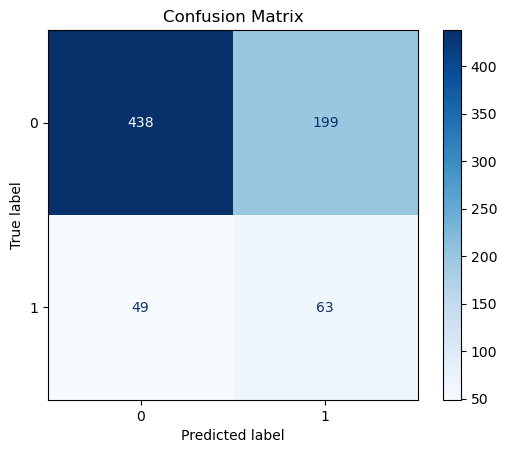

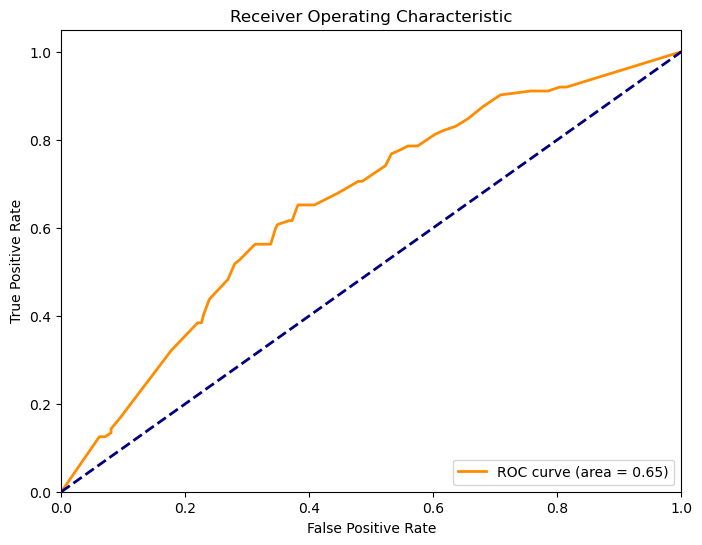


Training Time: 376.20 seconds


In [75]:
dt_trained_model, train_recall, test_recall, train_auc, test_auc = train_test_model(dt_models, X_train_scaled, y_train, X_test_scaled, y_test, gridsearch = True)

Best model parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 16}
Best model score is: 0.7552810200701104


Model Metrics:
           Train      Test
Recall  0.873527  0.526786
AUC     0.872485  0.627551

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.89      0.69      0.78       637
           1       0.23      0.53      0.32       112

    accuracy                           0.66       749
   macro avg       0.56      0.61      0.55       749
weighted avg       0.79      0.66      0.71       749



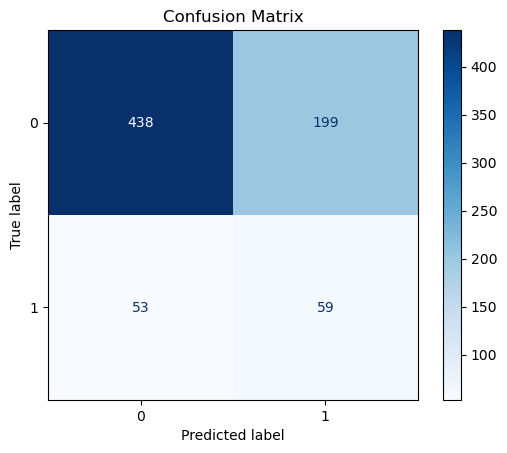

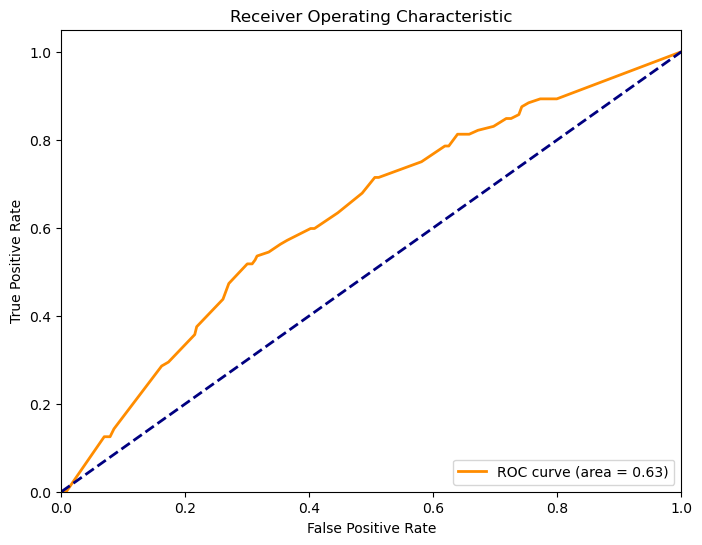


Training Time: 22.86 seconds


In [79]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': randint(3, 12),
    'min_samples_split': randint(10, 30),
    'min_samples_leaf': randint(5, 20),
    'criterion': ['gini', 'entropy'],
}

grid_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='recall', random_state=42)
ndt_trained_model, train_recall, test_recall, train_auc, test_auc = train_test_model(grid_search, X_train_scaled, y_train_smote, X_test_scaled, y_test, gridsearch = True)

In [119]:
X_smote, y_smote = smote.fit_resample(X, y)

In [121]:
X_smote.shape

(6366, 15)

In [122]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(
    X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42
)

In [123]:
X_smote_train.shape

(5092, 15)

In [124]:
X_smote_test.shape

(1274, 15)

Best model parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best model score is: 0.7477738939199093


Model Metrics:
           Train      Test
Recall  0.770621  0.766091
AUC     0.861469  0.838356

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       637
           1       0.74      0.77      0.75       637

    accuracy                           0.75      1274
   macro avg       0.75      0.75      0.75      1274
weighted avg       0.75      0.75      0.75      1274



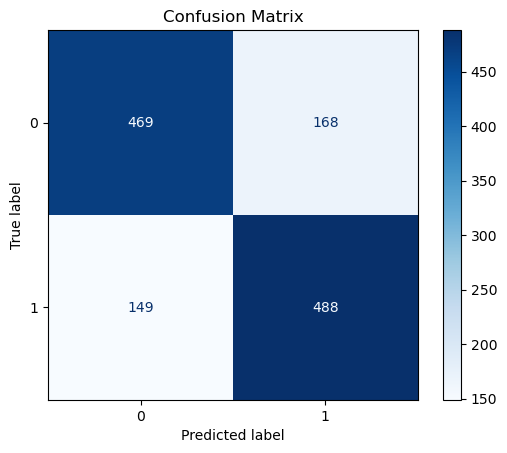

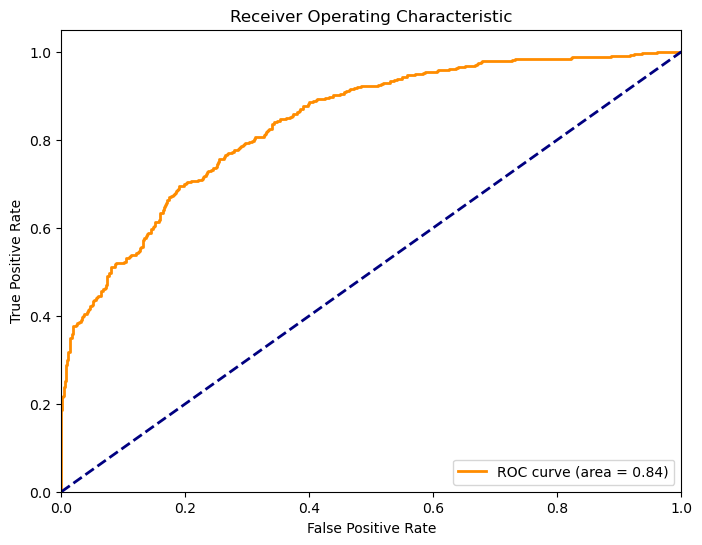


Training Time: 1514.59 seconds


In [125]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {
              'n_estimators':[50, 100, 200],
              'max_depth':[3, 4, 5],
              'min_samples_split':[10, 20, 25],
              'min_samples_leaf':[10, 20, 25]
              }
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_trained_model, train_recall, test_recall, train_auc, test_auc = train_test_model(GridSearchCV(rf_model, params_rf, 
                         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42), 
                         scoring = 'accuracy'), X_smote_train, y_smote_train, X_smote_test, y_smote_test,gridsearch=True)


Best model parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 75}
Best model score is: 0.9825853589634937


Model Metrics:
           Train      Test
Recall  1.000000  0.839286
AUC     0.970073  0.625456

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      0.28      0.43       637
           1       0.17      0.84      0.28       112

    accuracy                           0.37       749
   macro avg       0.54      0.56      0.36       749
weighted avg       0.80      0.37      0.41       749



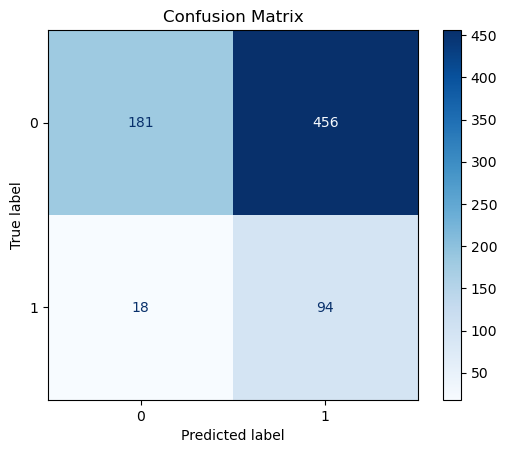

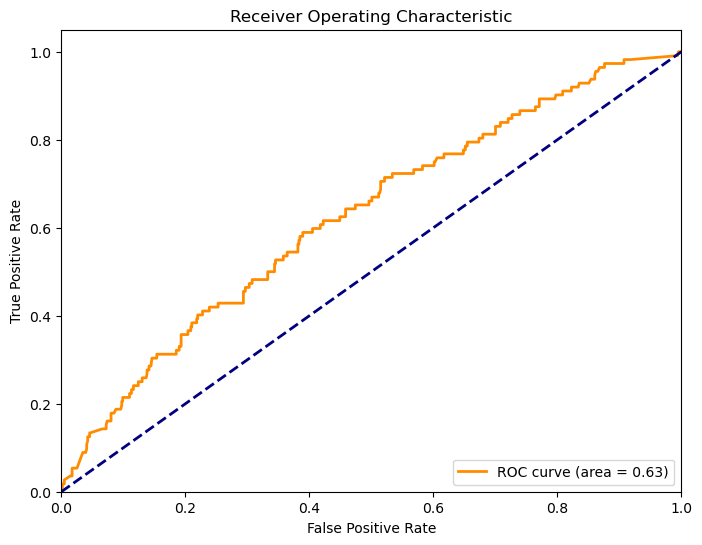


Training Time: 1162.50 seconds


In [116]:
import xgboost as xgb
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

params_xgb = {
              'n_estimators':[75,100, 150, 200],
              'max_depth':[10,15,20],
              'learning_rate':[0.01, 0.02]
              }

xgb_model = xgb.XGBClassifier(scale_pos_weight=ratio,random_state=42)
xgb_models = GridSearchCV(xgb_model, params_xgb, cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42), scoring = 'recall')
xgb_trained_model, train_recall, test_recall, train_auc, test_auc = train_test_model(xgb_models, X_train_smote, y_train_smote, X_test, y_test, gridsearch=True)

In [ ]:

scale_pos_weight=ratio
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp, shapiro
from sklearn.feature_selection import chi2



from sklearn.metrics import recall_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display